# Data Science Base Line Code

### Import

In [2]:
#Import문 - Import 추가로 할게 있다면 여기다가 해주세요
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


### 함수선언은 여기에 해주면 됨

In [3]:
#인코딩 / 라벨링함수
def encode_and_transform_dates(df):
    # 1. 라벨 인코딩할 열들 지정
    label_cols = ['Card Brand', 'Card Type', 'Error Message', 'Is Fraud?']
    
    # 2. 각 열에 대해 라벨 인코딩 수행
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 나중에 필요하면 인코더 저장 (복원할 때 사용 가능)
    
    # 3. 날짜 데이터를 8자리 숫자로 변환
    # 'Expires' 변환 (MM/YYYY -> YYYYMMDD)
    df['Expires'] = df['Expires'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 'Acct Open Date' 변환 (MM/YYYY -> YYYYMMDD)
    df['Acct Open Date'] = df['Acct Open Date'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 날짜 형식을 int 타입으로 변환
    df['Expires'] = df['Expires'].astype(int)
    df['Acct Open Date'] = df['Acct Open Date'].astype(int)
    
    # 인코딩된 데이터프레임 반환
    return df
#Is Fraud : Yes-1, No-0으로 Labeled


In [4]:
#Correlation Matrix 출력함수
def correlation_write(df, path='DS-main/datas/파생/correlation_matrix.csv'):
    # 상관관계 계산
    correlation_matrix = df.corr()
    
    # 상관관계 결과를 CSV로 저장
    correlation_matrix.to_csv(path)
    
    # 히트맵 그리기
    plt.figure(figsize=(10, 8)) 
    plt.title("Correlation Heatmap", fontsize=16)
    
    # Seaborn 히트맵 사용 (각 칸에 상관계수 표시)
    sns.heatmap(
        correlation_matrix, 
        annot=True,          # 상관계수 표시
        cmap='coolwarm', 
        linewidths=0.5, 
        fmt=".2f",           # 소수점 둘째 자리까지 표시
        annot_kws={"size": 10} # 상관계수 숫자의 글꼴 크기 지정
    )

    plt.tight_layout()
    plt.show()

In [5]:
# Classification Report, Confusion Matrix 출력함수
def print_classification_report_and_confusion_matrix(model, X_test, y_test):
    # 예측값 생성
    y_pred = model.predict(X_test)
    
    # 정확도 출력
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # 분류 리포트 출력 (Precision, Recall, F1-score 등)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix 출력
    cm = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    matrix.plot(cmap='coolwarm')
    for text in matrix.text_.ravel():
        text.set_color("black")
    plt.grid(False)
    plt.show()


In [6]:
#위의 출력한거 저장하는 함수 filename정해줘야함.
def save_classification_report_and_confusion_matrix(model, X_test, y_test, filename, output_dir="output1"):
    # 예측값 생성
    y_pred = model.predict(X_test)
    
    # 정확도 계산
    accuracy = accuracy_score(y_test, y_pred)
    
    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # classification report를 텍스트 파일로 저장
    report = classification_report(y_test, y_pred)
    report_file = os.path.join(output_dir, f"classification_report_{filename}.txt")
    with open(report_file, "w") as f:
        f.write(f"Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    
    # Confusion Matrix를 이미지 파일로 저장
    cm = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    matrix.plot(cmap='coolwarm')
    for text in matrix.text_.ravel():
        text.set_color("black")
    plt.grid(False)
    
    # 이미지 파일로 저장
    confusion_matrix_file = os.path.join(output_dir, f"confusion_matrix_{filename}.png")
    plt.savefig(confusion_matrix_file)
    plt.close()

    print(f"Classification report saved to {report_file}")
    print(f"Confusion matrix saved to {confusion_matrix_file}")

In [7]:
# 특정 컬럼 제거하는 함수
def drop_columns(dataframe, columns):
    
    # 컬럼이 데이터프레임에 존재하는지 확인
    existing_columns = [col for col in columns if col in dataframe.columns]
    missing_columns = [col for col in columns if col not in dataframe.columns]
    
    if existing_columns:
        dataframe = dataframe.drop(columns=existing_columns)
        print(f"다음 컬럼들이 제거되었습니다: {', '.join(existing_columns)}")
    
    if missing_columns:
        print(f"다음 컬럼들은 데이터프레임에 존재하지 않습니다: {', '.join(missing_columns)}")
    
    return dataframe



---
---
---  

### 여기서부터가 찐구현
#### 데이터 불러오기

Index(['User', 'Gender', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Zipcode', 'Per Capita Income - Zipcode',
       'Yearly Income', 'Total Debt', 'Credit Score', 'Year', 'Month', 'Day',
       'Merchandise Code', 'Card', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'Has Chip', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Amount', 'Whether Security Chip is Used',
       'Error Message', 'Is Fraud?'],
      dtype='object')


c:\Users\vml\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


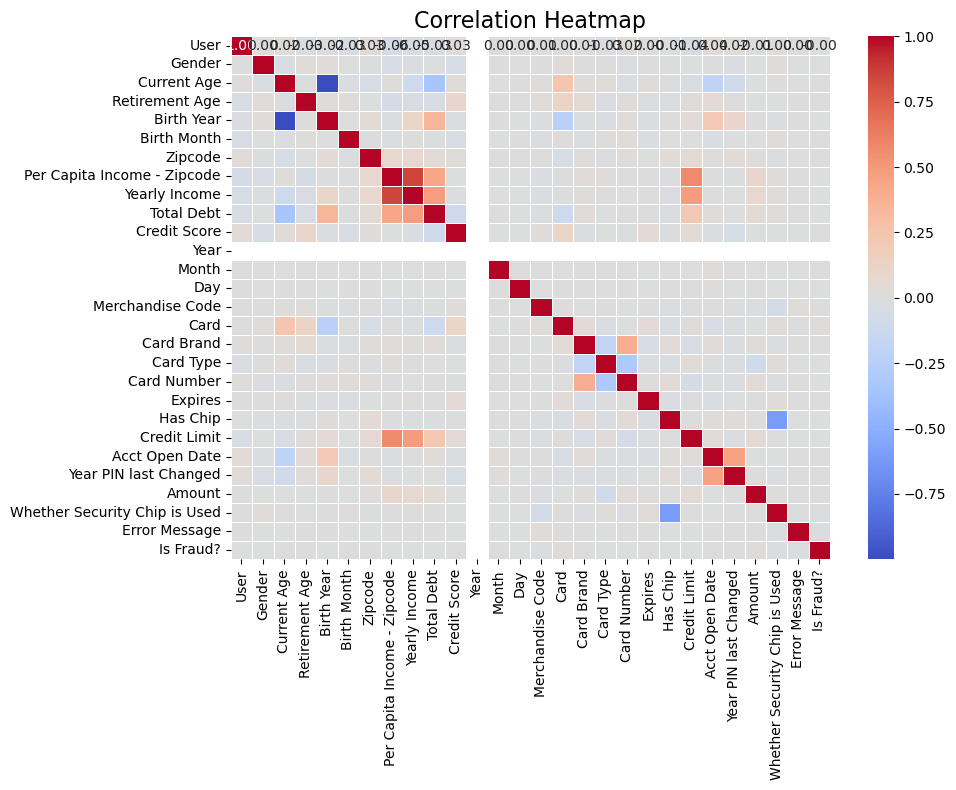

In [8]:
train_data = pd.read_csv('DS-main/datas/train.csv')
encode_and_transform_dates(train_data)
print(train_data.columns)
correlation_write(train_data)

In [ ]:
#제거할 컬럼 리스트
drop_list = ['Year', 'Month', 'Day', 'Amount', 'Merchandise Code']

train_data_modified = drop_columns(train_data, drop_list)


#### Train / Test Dataset 분리하기

In [35]:
X = train_data_modified.drop(columns=['Is Fraud?'])
y = train_data_modified['Is Fraud?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression

class_weight ='balanced'

In [ ]:
model = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced',max_iter=1000)
model.fit(X_train, y_train)

print_classification_report_and_confusion_matrix(model, X_test, y_test)
save_classification_report_and_confusion_matrix(model, X_test, y_test, "transx_LR", output_dir="output1")

### Balanced Random Forest

마찬가지로 아래의 class_weight='balanced'를 통해 구현

In [ ]:
rf=RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)
print_classification_report_and_confusion_matrix(rf, X_test, y_test)
save_classification_report_and_confusion_matrix(rf, X_test, y_test, "tarnsx_RF", output_dir="output1")

Random Forest는 자체적으로 Feature Importance를 추출할 수 있음 - 이에 대한 코드

In [ ]:
#Random Forest 결과물 -> Feature Importance 추출

importances = rf.feature_importances_
# 특성 이름과 중요도를 함께 보기 (X_train이 DataFrame일 때)
feature_names = X_train.columns  # X_train이 Pandas DataFrame일 때
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도가 높은 순서대로 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

#### SVM(Support Vector Machine)

In [ ]:
scaler = StandardScaler()
svm = make_pipeline(StandardScaler(),LinearSVC(penalty='l1',class_weight='balanced'))
svm.fit(X_train,y_train)
print_classification_report_and_confusion_matrix(svm, X_test, y_test)
save_classification_report_and_confusion_matrix(svm, X_test, y_test, "base", output_dir="output")

다음 컬럼들이 제거되었습니다: User
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


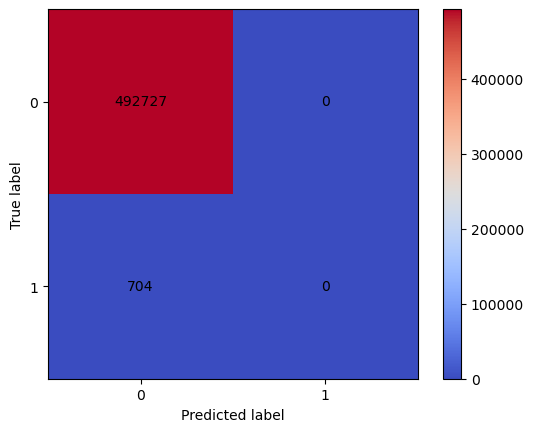

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_User.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_User.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.79      0.07      0.14       704

    accuracy                           1.00    493431
   macro avg       0.89      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



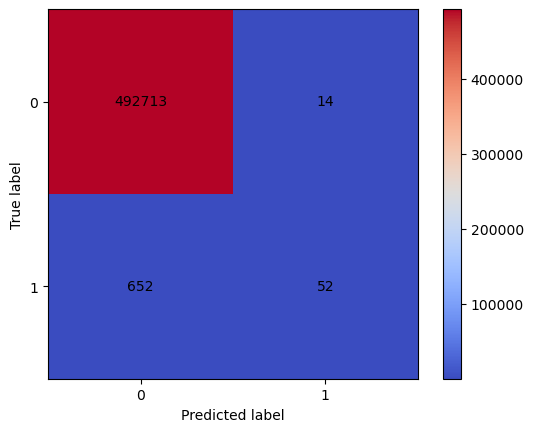

Classification report saved to output1\classification_report_RF_drop_User.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_User.png
다음 컬럼들이 제거되었습니다: Gender
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


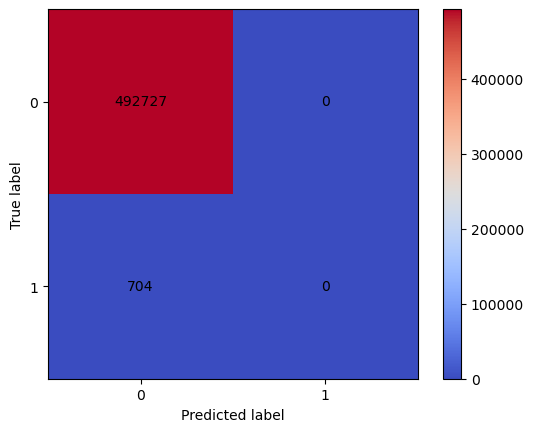

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Gender.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Gender.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.80      0.09      0.17       704

    accuracy                           1.00    493431
   macro avg       0.90      0.55      0.58    493431
weighted avg       1.00      1.00      1.00    493431



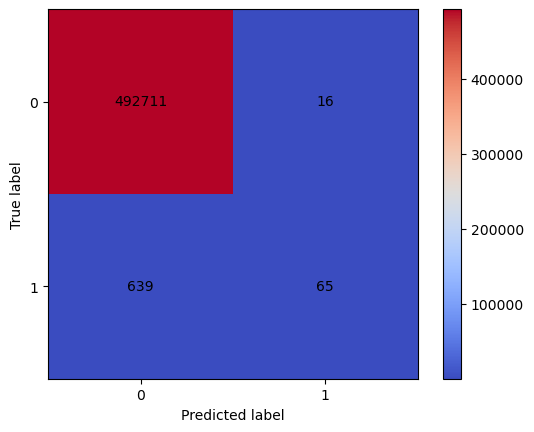

Classification report saved to output1\classification_report_RF_drop_Gender.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Gender.png
다음 컬럼들이 제거되었습니다: Current Age
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


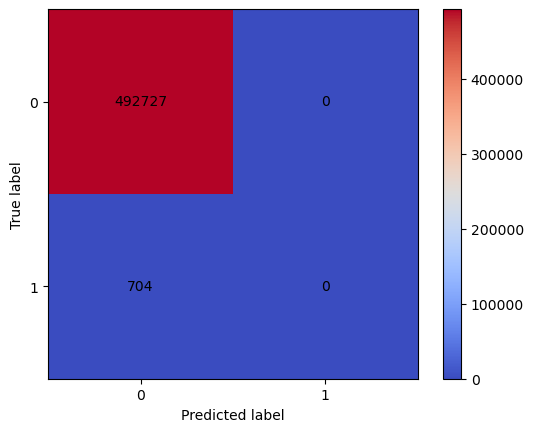

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Current Age.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Current Age.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.84      0.09      0.16       704

    accuracy                           1.00    493431
   macro avg       0.92      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



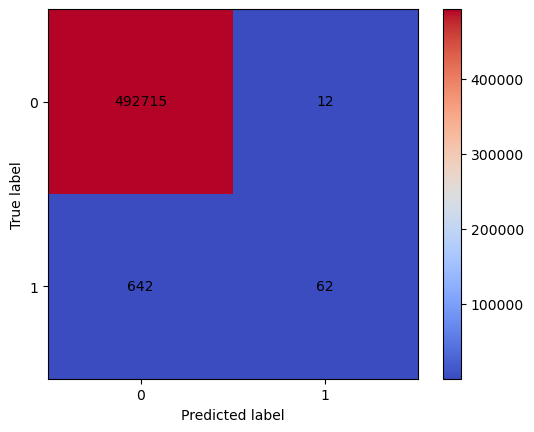

Classification report saved to output1\classification_report_RF_drop_Current Age.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Current Age.png
다음 컬럼들이 제거되었습니다: Retirement Age
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


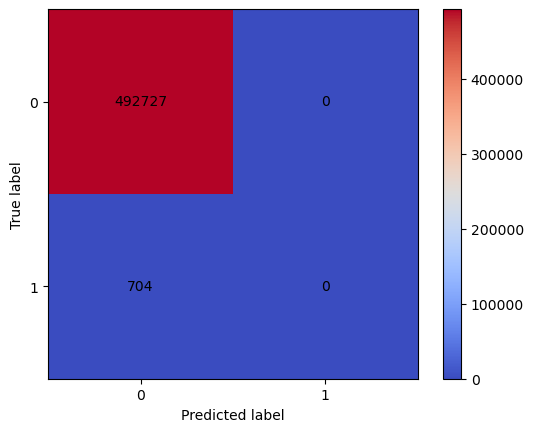

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Retirement Age.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Retirement Age.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.83      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



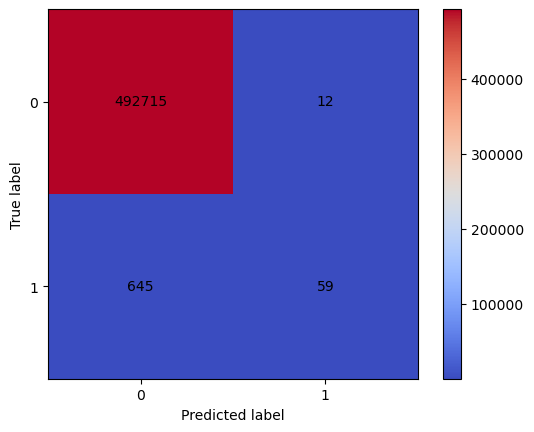

Classification report saved to output1\classification_report_RF_drop_Retirement Age.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Retirement Age.png
다음 컬럼들이 제거되었습니다: Birth Year
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


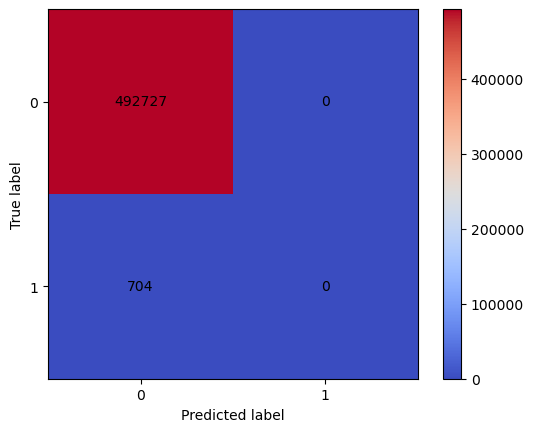

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Birth Year.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Birth Year.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



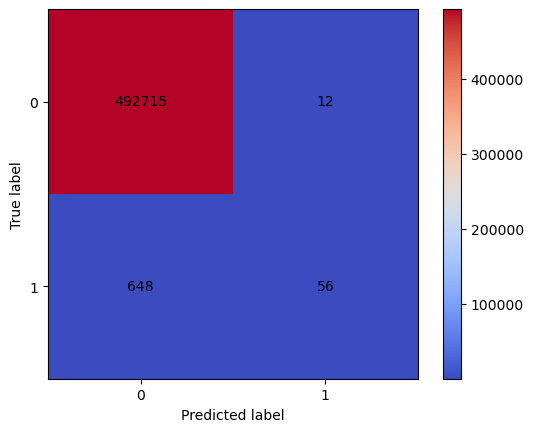

Classification report saved to output1\classification_report_RF_drop_Birth Year.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Birth Year.png
다음 컬럼들이 제거되었습니다: Birth Month
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


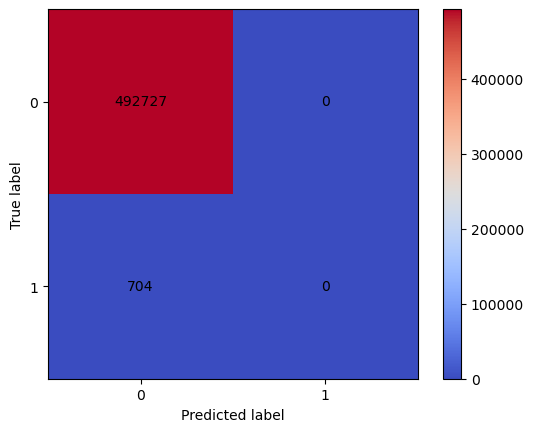

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Birth Month.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Birth Month.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.09      0.16       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



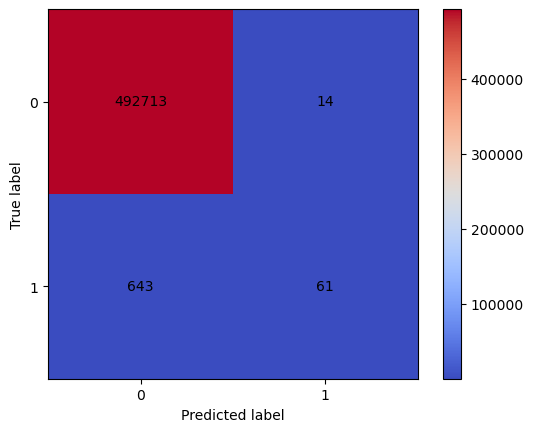

Classification report saved to output1\classification_report_RF_drop_Birth Month.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Birth Month.png
다음 컬럼들이 제거되었습니다: Zipcode
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


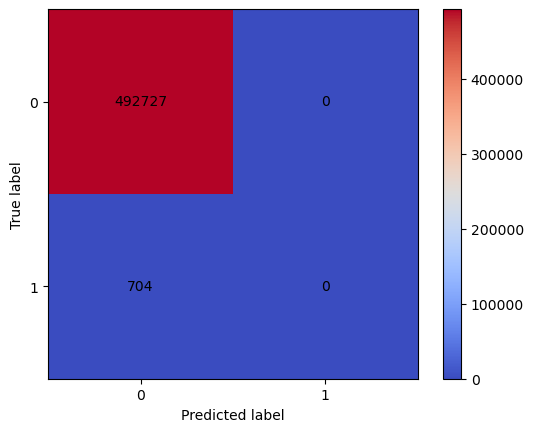

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Zipcode.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Zipcode.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.90      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



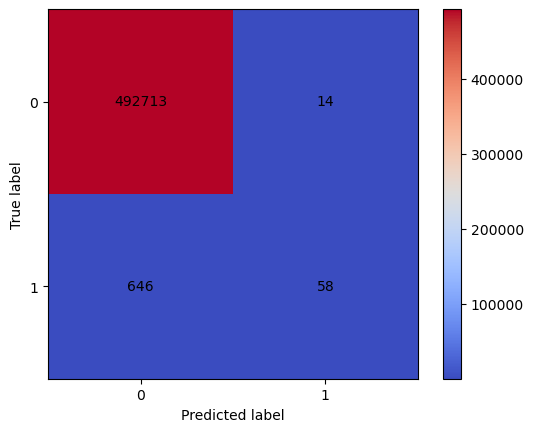

Classification report saved to output1\classification_report_RF_drop_Zipcode.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Zipcode.png
다음 컬럼들이 제거되었습니다: Per Capita Income - Zipcode
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


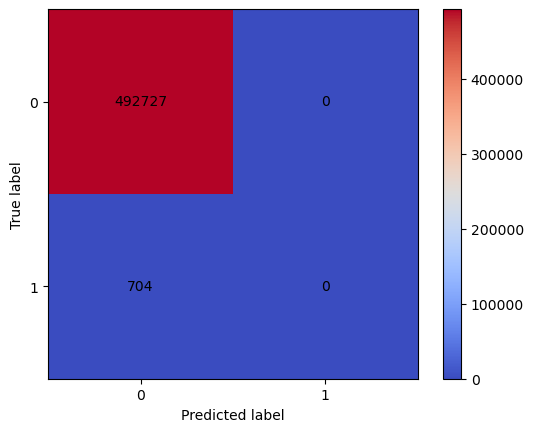

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Per Capita Income - Zipcode.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Per Capita Income - Zipcode.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.90      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



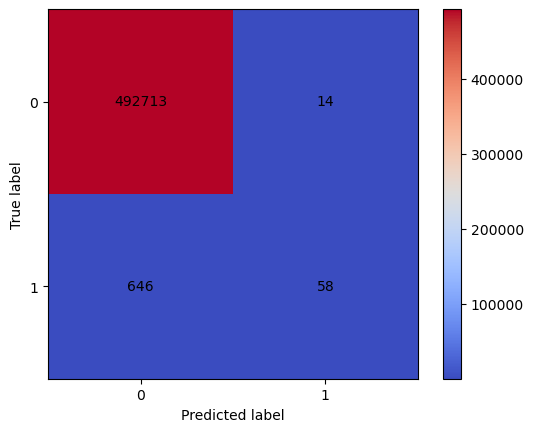

Classification report saved to output1\classification_report_RF_drop_Per Capita Income - Zipcode.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Per Capita Income - Zipcode.png
다음 컬럼들이 제거되었습니다: Yearly Income
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


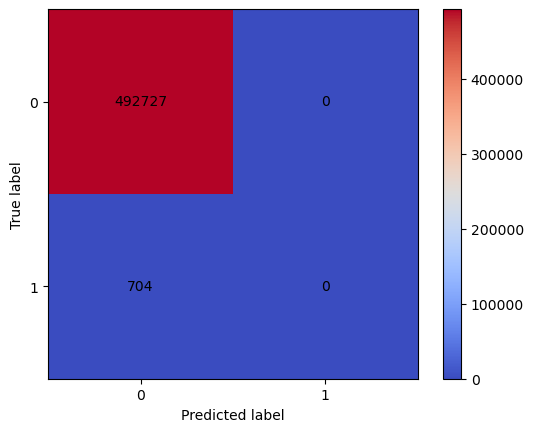

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Yearly Income.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Yearly Income.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.08      0.14       704

    accuracy                           1.00    493431
   macro avg       0.90      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



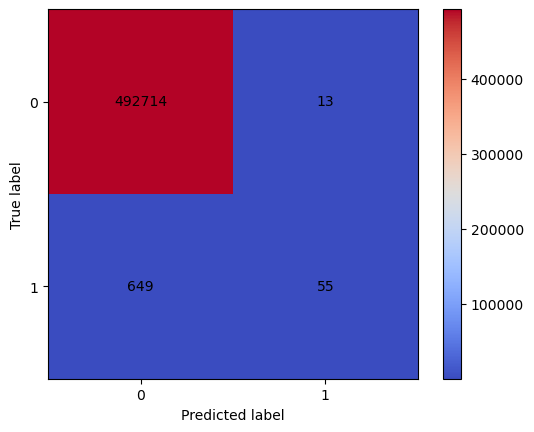

Classification report saved to output1\classification_report_RF_drop_Yearly Income.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Yearly Income.png
다음 컬럼들이 제거되었습니다: Total Debt
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


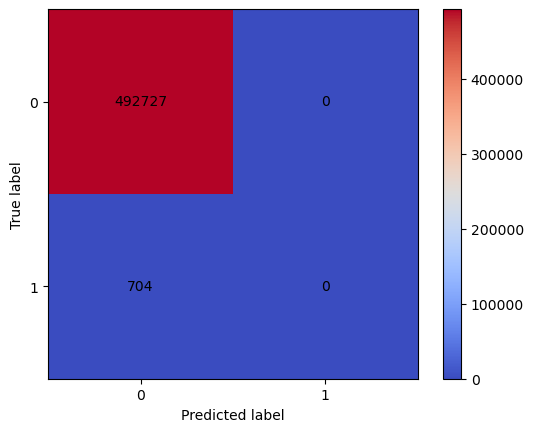

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Total Debt.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Total Debt.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.08      0.14       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



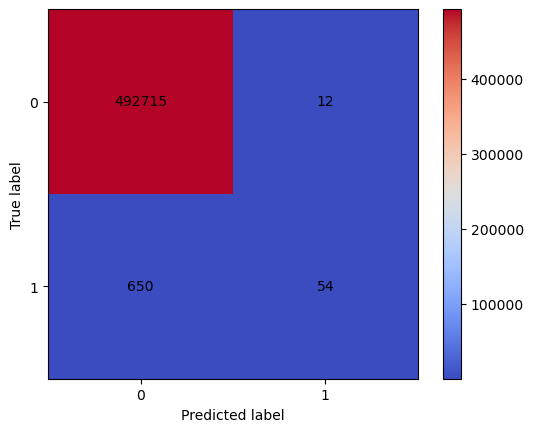

Classification report saved to output1\classification_report_RF_drop_Total Debt.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Total Debt.png
다음 컬럼들이 제거되었습니다: Credit Score
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


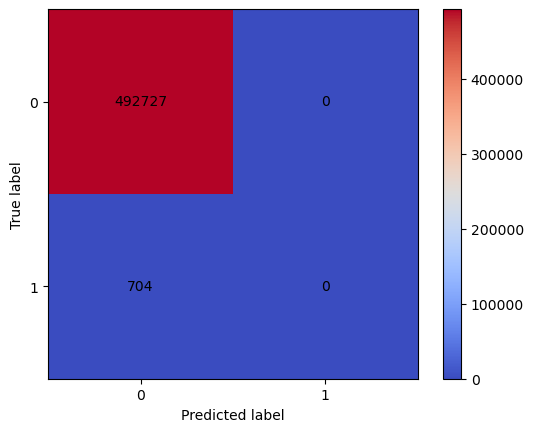

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Credit Score.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Credit Score.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.09      0.15       704

    accuracy                           1.00    493431
   macro avg       0.90      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



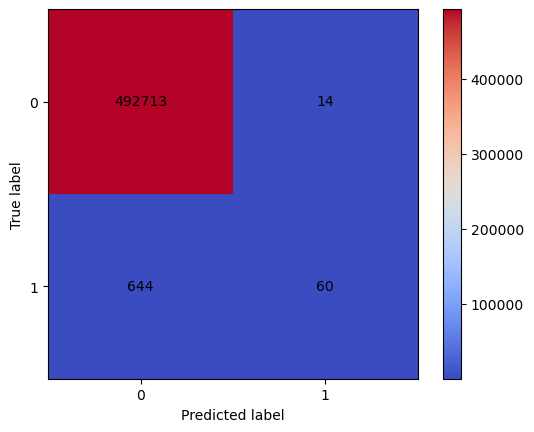

Classification report saved to output1\classification_report_RF_drop_Credit Score.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Credit Score.png
다음 컬럼들이 제거되었습니다: Card
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


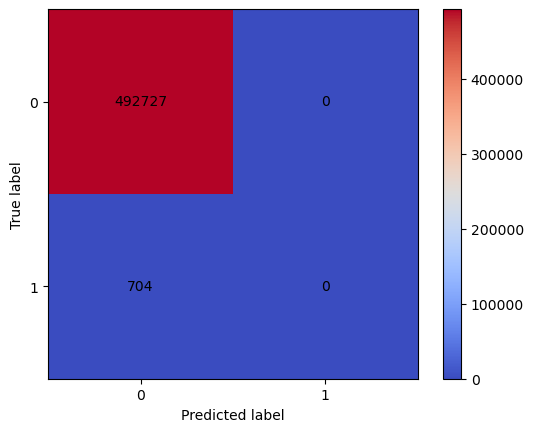

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Card.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Card.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.85      0.09      0.16       704

    accuracy                           1.00    493431
   macro avg       0.93      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



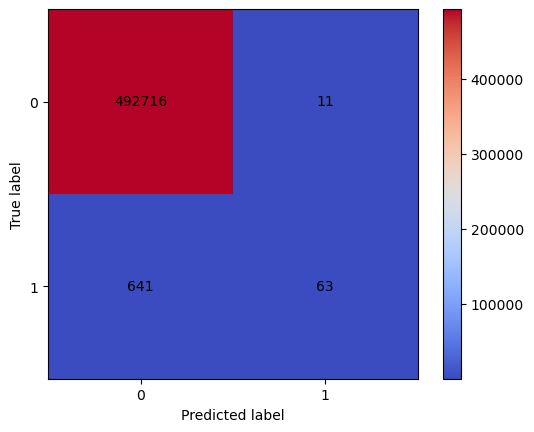

Classification report saved to output1\classification_report_RF_drop_Card.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Card.png
다음 컬럼들이 제거되었습니다: Card Brand
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


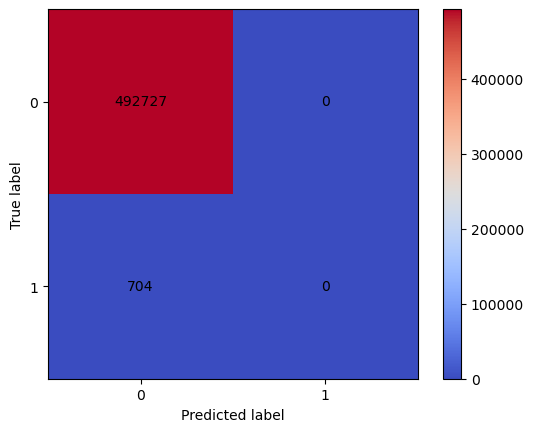

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Card Brand.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Card Brand.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



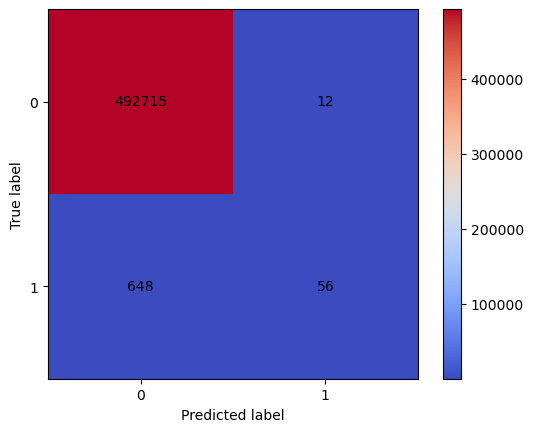

Classification report saved to output1\classification_report_RF_drop_Card Brand.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Card Brand.png
다음 컬럼들이 제거되었습니다: Card Type
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


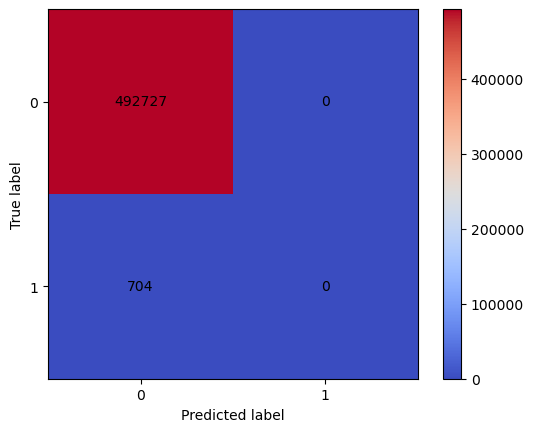

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Card Type.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Card Type.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



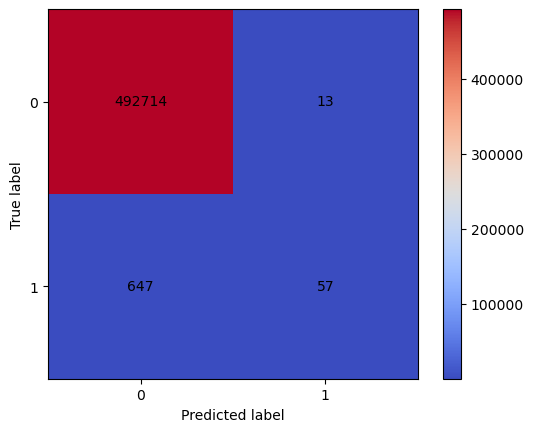

Classification report saved to output1\classification_report_RF_drop_Card Type.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Card Type.png
다음 컬럼들이 제거되었습니다: Card Number
Accuracy: 0.5622

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72    492727
           1       0.00      0.56      0.00       704

    accuracy                           0.56    493431
   macro avg       0.50      0.56      0.36    493431
weighted avg       1.00      0.56      0.72    493431



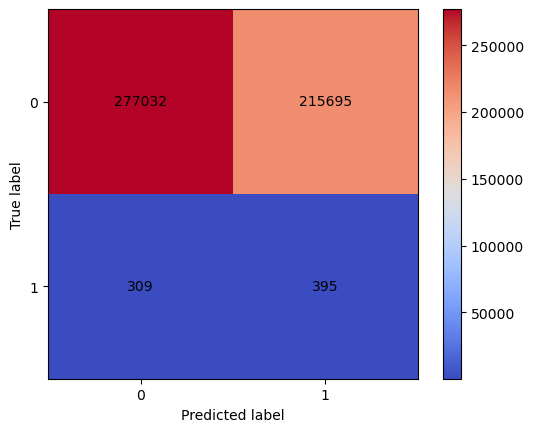

Classification report saved to output1\classification_report_LR_drop_Card Number.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Card Number.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.84      0.08      0.14       704

    accuracy                           1.00    493431
   macro avg       0.92      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



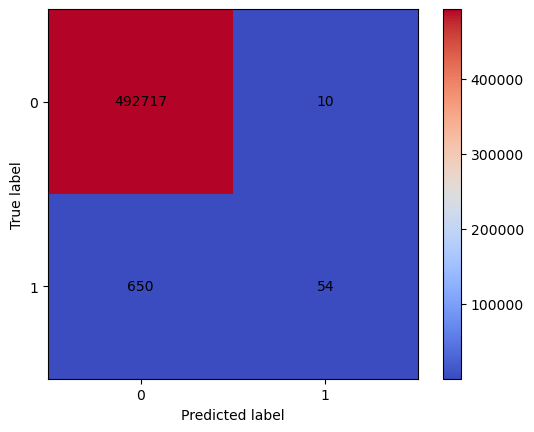

Classification report saved to output1\classification_report_RF_drop_Card Number.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Card Number.png
다음 컬럼들이 제거되었습니다: Expires
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


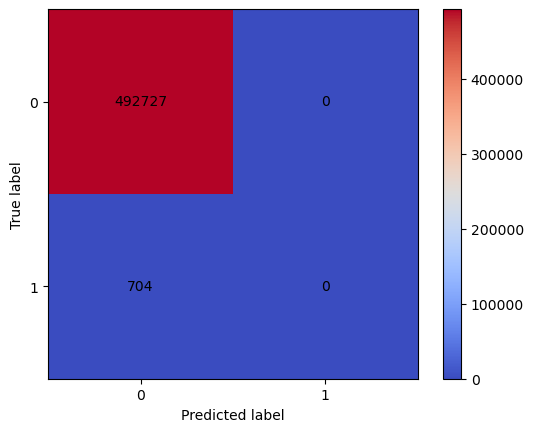

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Expires.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Expires.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.09      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



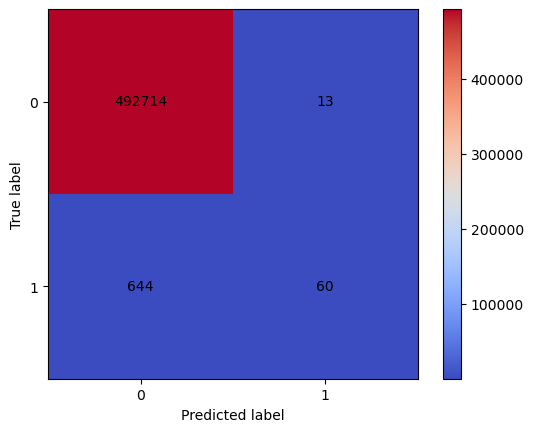

Classification report saved to output1\classification_report_RF_drop_Expires.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Expires.png
다음 컬럼들이 제거되었습니다: Has Chip
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


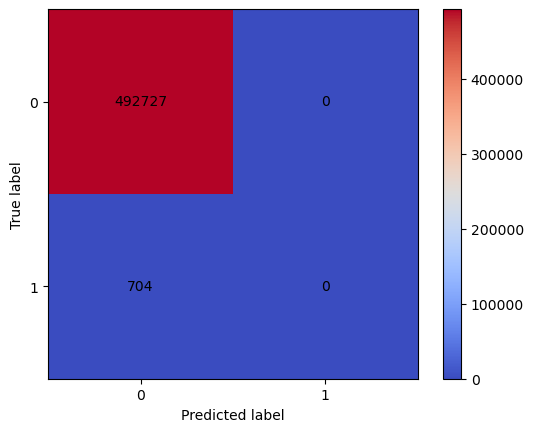

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Has Chip.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Has Chip.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.77      0.08      0.14       704

    accuracy                           1.00    493431
   macro avg       0.88      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



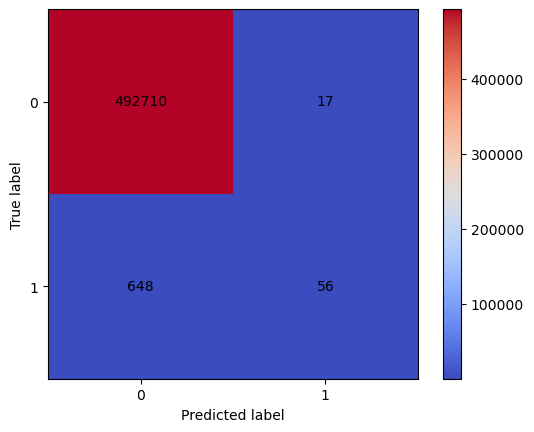

Classification report saved to output1\classification_report_RF_drop_Has Chip.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Has Chip.png
다음 컬럼들이 제거되었습니다: Credit Limit
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


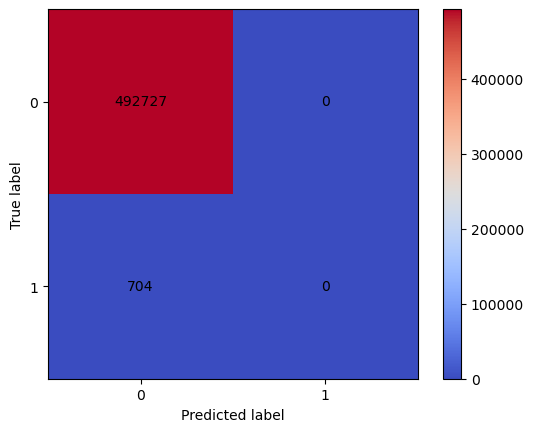

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Credit Limit.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Credit Limit.png
Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.76      0.07      0.13       704

    accuracy                           1.00    493431
   macro avg       0.88      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



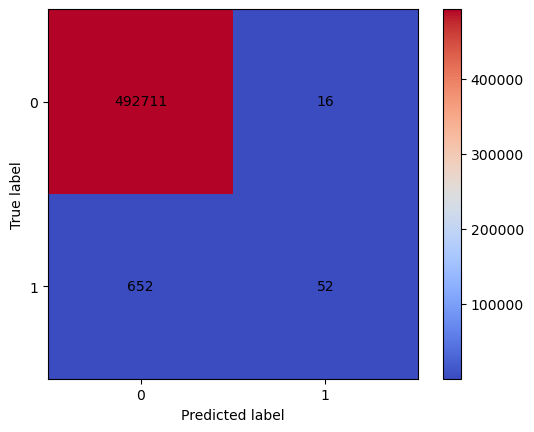

Classification report saved to output1\classification_report_RF_drop_Credit Limit.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Credit Limit.png
다음 컬럼들이 제거되었습니다: Acct Open Date
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


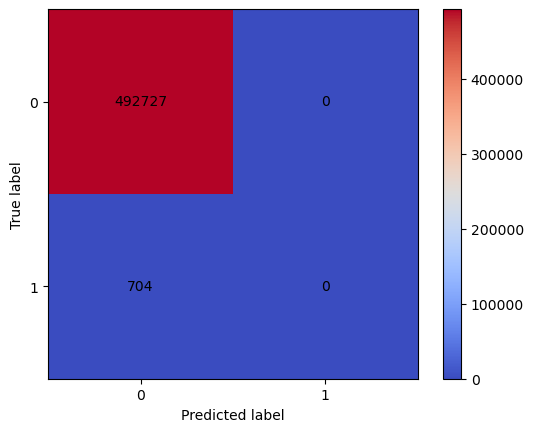

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Acct Open Date.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Acct Open Date.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.08      0.15       704

    accuracy                           1.00    493431
   macro avg       0.91      0.54      0.58    493431
weighted avg       1.00      1.00      1.00    493431



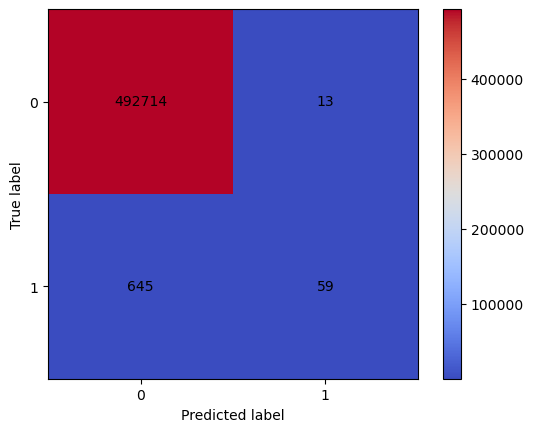

Classification report saved to output1\classification_report_RF_drop_Acct Open Date.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Acct Open Date.png
다음 컬럼들이 제거되었습니다: Year PIN last Changed
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


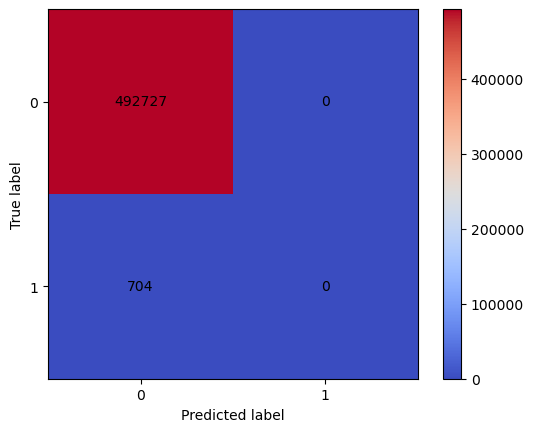

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Year PIN last Changed.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Year PIN last Changed.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.79      0.07      0.14       704

    accuracy                           1.00    493431
   macro avg       0.89      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



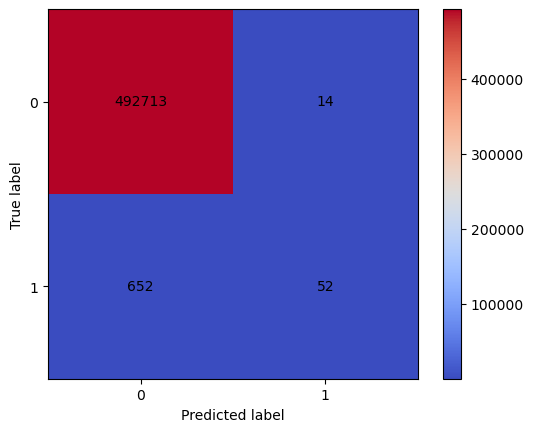

Classification report saved to output1\classification_report_RF_drop_Year PIN last Changed.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Year PIN last Changed.png
다음 컬럼들이 제거되었습니다: Year
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


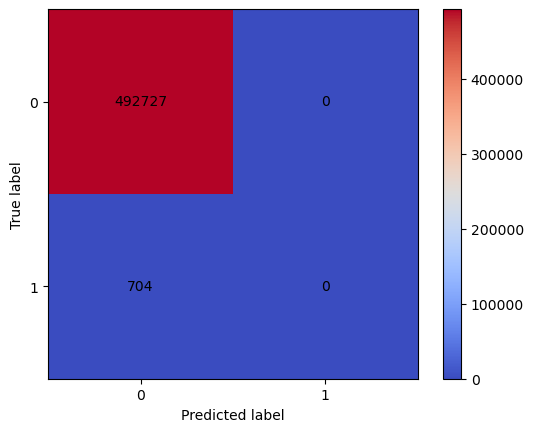

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Year.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Year.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.82      0.09      0.17       704

    accuracy                           1.00    493431
   macro avg       0.91      0.55      0.58    493431
weighted avg       1.00      1.00      1.00    493431



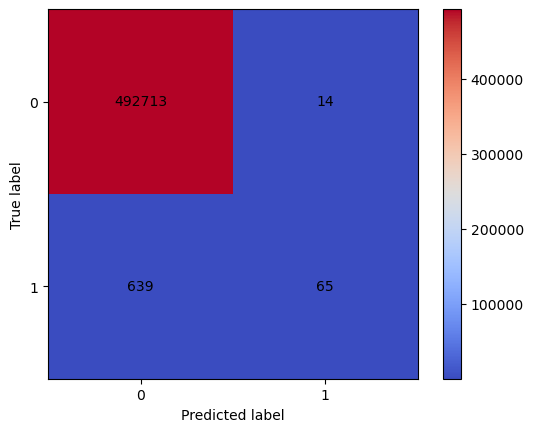

Classification report saved to output1\classification_report_RF_drop_Year.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Year.png
다음 컬럼들이 제거되었습니다: Month
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


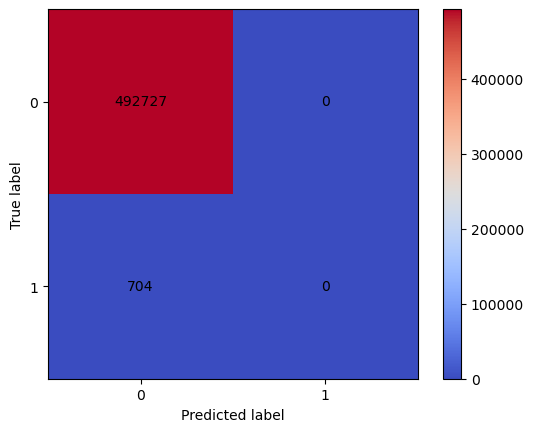

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Month.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Month.png
Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.52      0.04      0.07       704

    accuracy                           1.00    493431
   macro avg       0.76      0.52      0.54    493431
weighted avg       1.00      1.00      1.00    493431



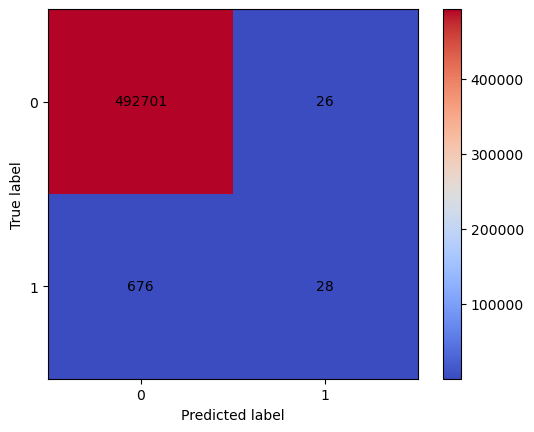

Classification report saved to output1\classification_report_RF_drop_Month.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Month.png
다음 컬럼들이 제거되었습니다: Day
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


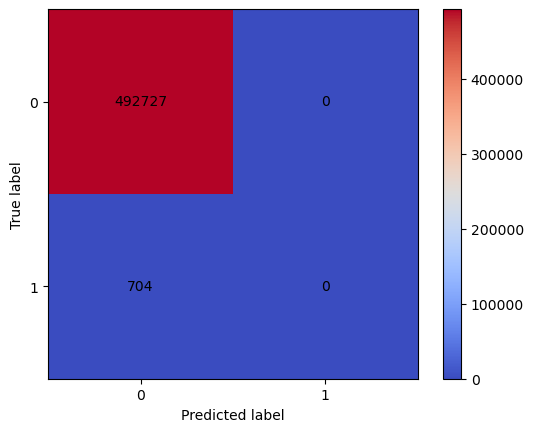

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Day.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Day.png
Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.50      0.08      0.14       704

    accuracy                           1.00    493431
   macro avg       0.75      0.54      0.57    493431
weighted avg       1.00      1.00      1.00    493431



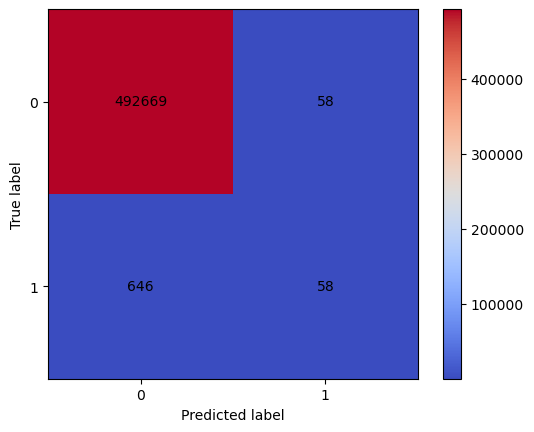

Classification report saved to output1\classification_report_RF_drop_Day.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Day.png
다음 컬럼들이 제거되었습니다: Amount
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



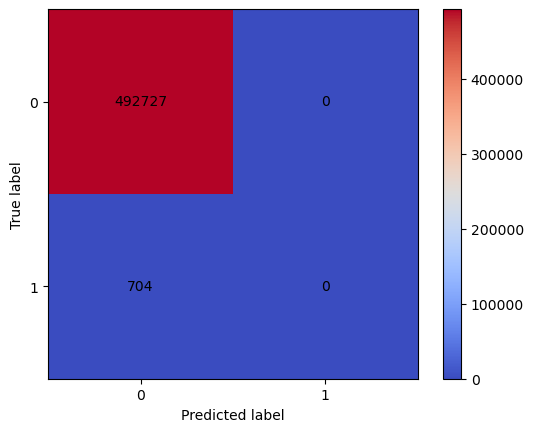

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Amount.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Amount.png
Accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.73      0.25      0.37       704

    accuracy                           1.00    493431
   macro avg       0.87      0.62      0.68    493431
weighted avg       1.00      1.00      1.00    493431



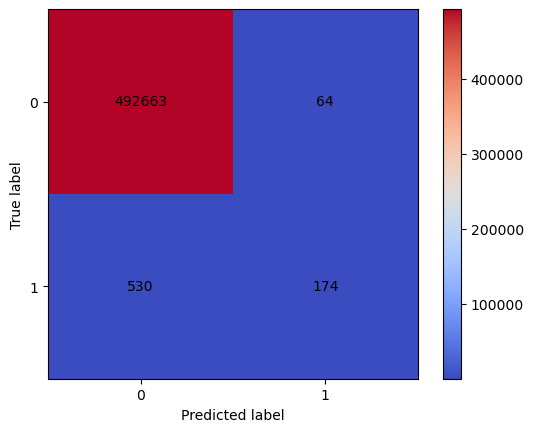

Classification report saved to output1\classification_report_RF_drop_Amount.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Amount.png
다음 컬럼들이 제거되었습니다: Merchandise Code
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


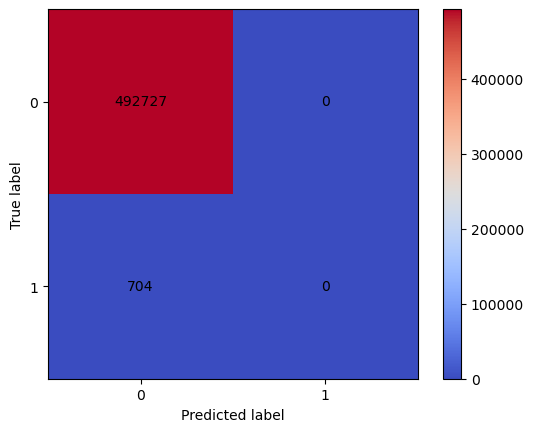

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Merchandise Code.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Merchandise Code.png
Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.58      0.18      0.27       704

    accuracy                           1.00    493431
   macro avg       0.79      0.59      0.63    493431
weighted avg       1.00      1.00      1.00    493431



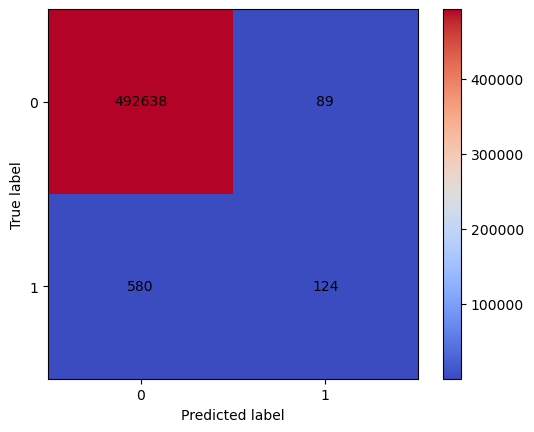

Classification report saved to output1\classification_report_RF_drop_Merchandise Code.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Merchandise Code.png
다음 컬럼들이 제거되었습니다: Whether Security Chip is Used
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


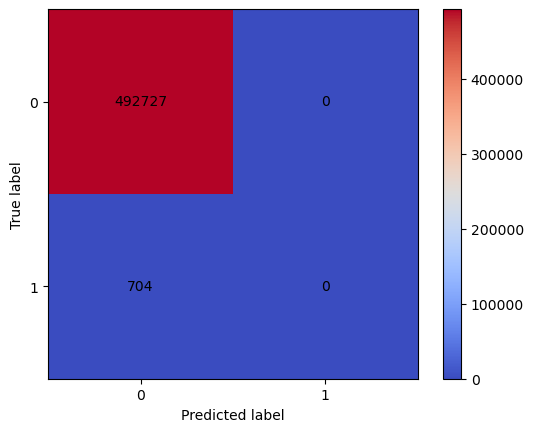

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Whether Security Chip is Used.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Whether Security Chip is Used.png
Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.67      0.05      0.09       704

    accuracy                           1.00    493431
   macro avg       0.83      0.53      0.55    493431
weighted avg       1.00      1.00      1.00    493431



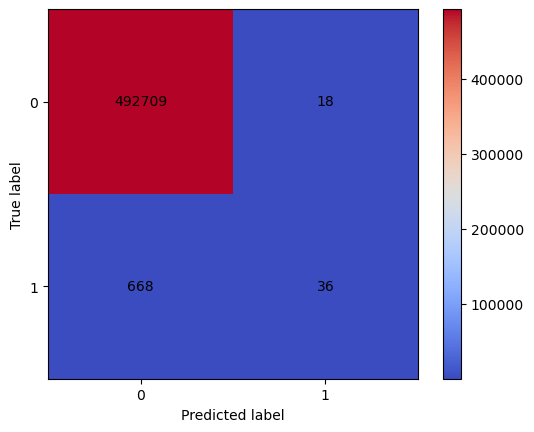

Classification report saved to output1\classification_report_RF_drop_Whether Security Chip is Used.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Whether Security Chip is Used.png
다음 컬럼들이 제거되었습니다: Error Message
Accuracy: 0.9986

Classification Report:


c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.00      0.00      0.00       704

    accuracy                           1.00    493431
   macro avg       0.50      0.50      0.50    493431
weighted avg       1.00      1.00      1.00    493431



c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


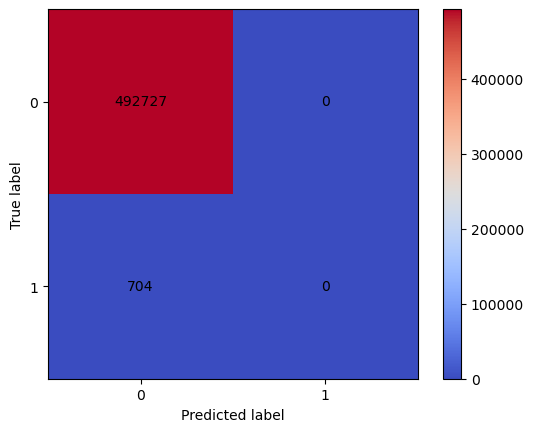

c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vml\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report saved to output1\classification_report_LR_drop_Error Message.txt
Confusion matrix saved to output1\confusion_matrix_LR_drop_Error Message.png
Accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    492727
           1       0.81      0.09      0.17       704

    accuracy                           1.00    493431
   macro avg       0.91      0.55      0.58    493431
weighted avg       1.00      1.00      1.00    493431



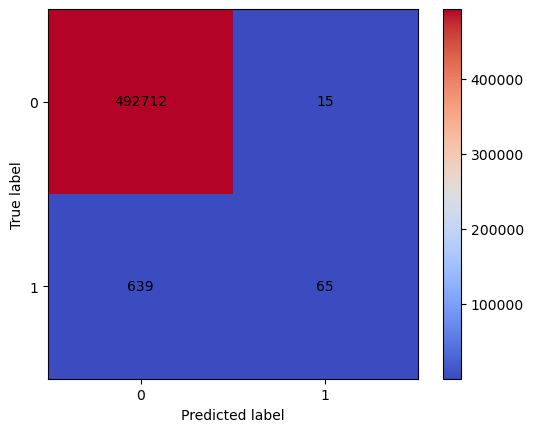

Classification report saved to output1\classification_report_RF_drop_Error Message.txt
Confusion matrix saved to output1\confusion_matrix_RF_drop_Error Message.png


In [9]:
# Main loop
drop_list =  ['User', 'Gender', 'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Zipcode',
                  'Per Capita Income - Zipcode', 'Yearly Income', 'Total Debt', 'Credit Score','Card', 'Card Brand', 'Card Type', 'Card Number', 'Expires', 'Has Chip',
                  'Credit Limit', 'Acct Open Date', 'Year PIN last Changed','Year', 'Month', 'Day', 'Amount', 'Merchandise Code','Whether Security Chip is Used', 'Error Message']


# 컬럼 리스트에서 하나씩 제거하며 반복
for i in range(len(drop_list)):
    # i번째 컬럼만 제거
    columns_to_drop = [drop_list[i]]
    train_data_modified = drop_columns(train_data.copy(), columns_to_drop)
    
    # 학습/테스트 데이터 분리
    X = train_data_modified.drop(columns=['Is Fraud?'])
    y = train_data_modified['Is Fraud?']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Logistic Regression 모델 훈련 및 결과 저장
    model = LogisticRegression(penalty='l2', fit_intercept=False, class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    
    print_classification_report_and_confusion_matrix(model, X_test, y_test)
    save_classification_report_and_confusion_matrix(model, X_test, y_test, f"LR_drop_{drop_list[i]}", output_dir="output1")
    
    # Random Forest 모델 훈련 및 결과 저장
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    
    print_classification_report_and_confusion_matrix(rf, X_test, y_test)
    save_classification_report_and_confusion_matrix(rf, X_test, y_test, f"RF_drop_{drop_list[i]}", output_dir="output1")